pygame 2.6.1 (SDL 2.28.4, Python 3.13.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\DELL\AppData\Local\Temp\ipykernel_3352\407668364.py:71: RuntimeWarning: divide by zero encountered in scalar divide
  force_magnitude *= (1 - 0.5 * rel_vel_factor / my_speed)



=== Force Analysis ===
Average Driving Force: 0.94
Average Agent Interaction Force: 1.23
Average Wall Force: 9.78

=== Average Direction Changes (degrees) ===
Track 3: 28.69°
Track 5: 24.24°
Track 9: 13.43°
Track 13: 13.65°


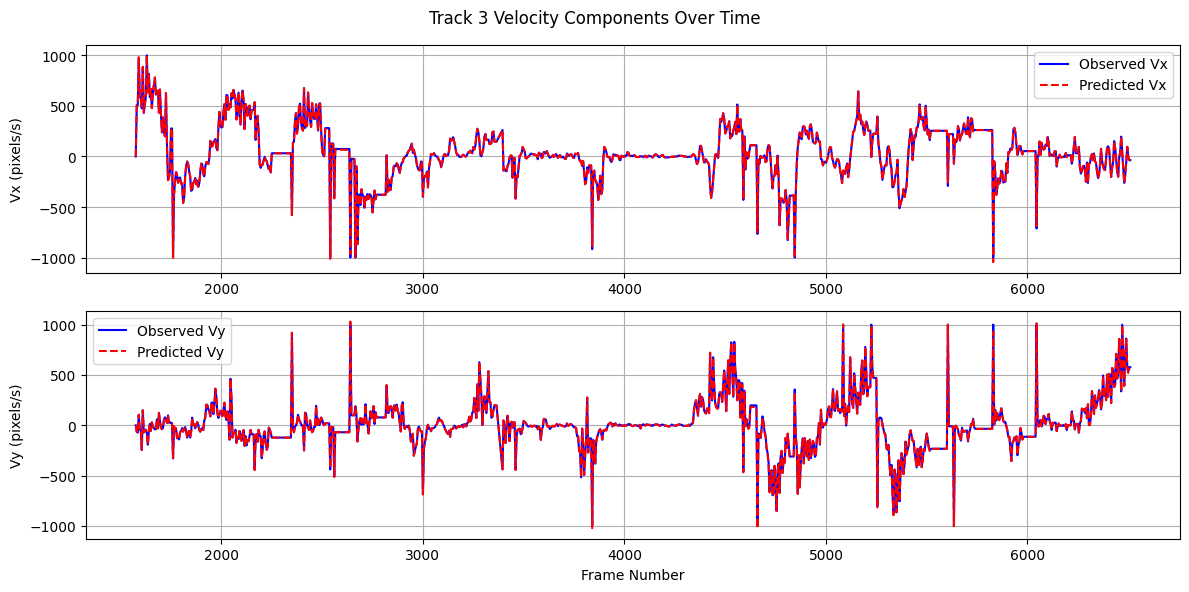

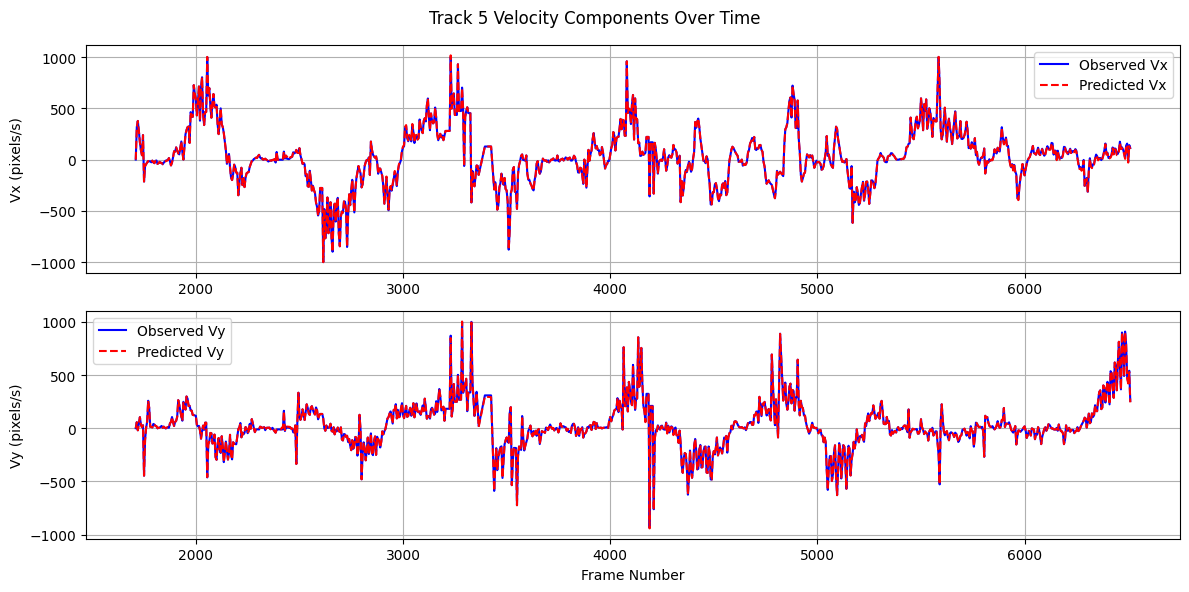

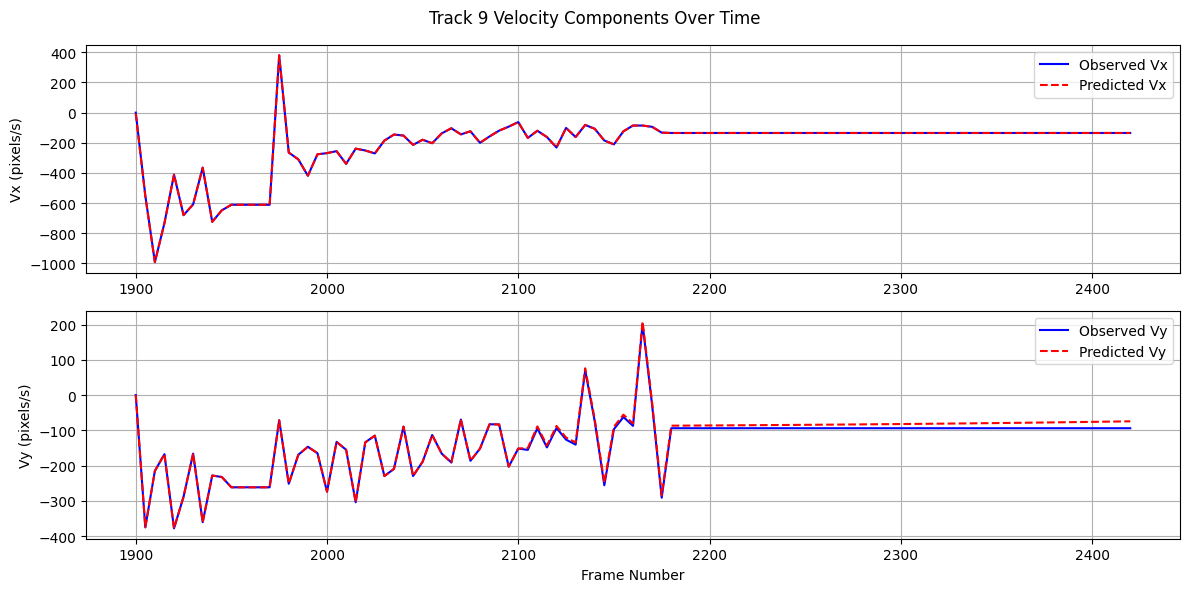

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pygame

# Start Pygame for visualization
pygame.init()

# Define constants for the simulation
SCALE = 100  # Pixels per meter for scaling positions
dt = 0.2     # Time step (seconds), based on 5 frames at 25 fps
EPSILON = 1e-6  # Tiny value to avoid division by zero
SOCIAL_FORCE_LAMBDA = 2.0  # Factor for anisotropic agent interactions
WALL_DECAY_LENGTH = 150.0  # How fast wall repulsion decreases with distance
MAX_FORCE = 1e4  # Limit for forces to prevent crazy values
MAX_VELOCITY = 1e3  # Limit for velocities to keep things realistic

# Tuned parameters to make the model work better
DRIVING_FORCE_TAU = 1.5  # Smoother acceleration with this relaxation time
AGENT_INTERACTION_RANGE = 1.5 * SCALE  # Distance for agents to affect each other
AGENT_REPULSION_STRENGTH = 30.0  # Stronger push between agents
WALL_INTERACTION_RANGE = 2.0 * SCALE  # Distance for wall effects
WALL_REPULSION_STRENGTH = 100.0  # Strength of wall repulsion

# Class for each pedestrian in the simulation
class PedestrianAgent:
    def __init__(self, x, y, track_id, desired_direction, desired_speed):
        # Set up the agent with position, ID, and desired movement
        self.position = np.array([x, y], dtype=float)
        self.desired_speed = float(desired_speed) if np.isfinite(desired_speed) else 0.0
        self.velocity = np.array([0.0, 0.0], dtype=float)
        self.radius = 0.2 * SCALE
        self.track_id = track_id
        self.desired_direction = np.array(desired_direction, dtype=float)
        # Normalize the direction if it's not zero
        if np.linalg.norm(self.desired_direction) > 0:
            self.desired_direction /= np.linalg.norm(self.desired_direction)
        self.previous_speed = self.desired_speed
        self.path = []  # Store path for drawing

    def driving_force(self):
        # Calculate the force to move toward desired velocity
        desired_velocity = self.desired_direction * self.previous_speed
        force = (desired_velocity - self.velocity) / DRIVING_FORCE_TAU
        if not np.all(np.isfinite(force)):
            return np.zeros(2, dtype=float)
        return np.clip(force, -MAX_FORCE, MAX_FORCE)

    def agent_interaction_force(self, agents):
        # Calculate repulsion from other agents
        total_force = np.zeros(2, dtype=float)
        my_speed = np.linalg.norm(self.velocity)

        for agent in agents:
            if agent != self:
                diff = self.position - agent.position
                distance = np.linalg.norm(diff)
                
                if distance < AGENT_INTERACTION_RANGE:
                    direction = diff / (distance + EPSILON)
                    # Add anisotropic effect based on movement direction
                    anisotropic_factor = 1.0
                    if my_speed > 0.1:
                        velocity_dir = self.velocity / my_speed
                        cos_phi = np.dot(direction, velocity_dir)
                        anisotropic_factor = SOCIAL_FORCE_LAMBDA + (1 - SOCIAL_FORCE_LAMBDA) * (1 + cos_phi) / 2
                    rel_vel = self.velocity - agent.velocity
                    rel_vel_factor = np.dot(rel_vel, direction)
                    force_magnitude = AGENT_REPULSION_STRENGTH * np.exp(-distance / (self.radius + agent.radius))
                    if rel_vel_factor > 0:
                        force_magnitude *= (1 - 0.5 * rel_vel_factor / my_speed)
                    force_contribution = direction * force_magnitude * anisotropic_factor
                    if np.all(np.isfinite(force_contribution)):
                        total_force += force_contribution
        
        return np.clip(total_force, -MAX_FORCE, MAX_FORCE)

    def wall_interaction_force(self, walls):
        # Calculate repulsion from walls
        total_force = np.zeros(2, dtype=float)
        
        for wall in walls:
            nearest_point = wall.get_nearest_point(self.position)
            distance_to_wall = np.linalg.norm(nearest_point - self.position)
            
            if distance_to_wall < WALL_INTERACTION_RANGE:
                direction = (self.position - nearest_point) / (distance_to_wall + EPSILON)
                force_magnitude = WALL_REPULSION_STRENGTH * np.exp(-distance_to_wall / WALL_DECAY_LENGTH)
                force_contribution = direction * force_magnitude
                if np.all(np.isfinite(force_contribution)):
                    total_force += force_contribution
        
        return np.clip(total_force, -MAX_FORCE, MAX_FORCE)

    def get_position(self):
        # Return current position
        return self.position

# Class for walls in the simulation
class SimulationWall:
    def __init__(self, start, end):
        # Set up a wall with start and end points
        self.start = np.array(start, dtype=float)
        self.end = np.array(end, dtype=float)

    def get_nearest_point(self, position):
        # Find the closest point on the wall to a position
        line_vector = self.end - self.start
        point_vector = position - self.start
        line_length = np.linalg.norm(line_vector)
        if line_length < EPSILON:
            return self.start.copy()
        line_unit_vector = line_vector / line_length
        projection_length = np.dot(point_vector, line_unit_vector)
        projection_length = max(0, min(projection_length, line_length))
        return self.start + projection_length * line_unit_vector

# Class to manage the whole simulation
class SocialForceSimulation:
    def __init__(self):
        # Start with empty lists for agents and walls
        self.agents = []
        self.walls = []

    def add_agent(self, agent):
        # Add an agent to the simulation
        self.agents.append(agent)

    def add_wall(self, wall):
        # Add a wall to the simulation
        self.walls.append(wall)

    def get_agents_positions(self):
        # Get positions of all agents
        return [agent.get_position() for agent in self.agents]

# Load and clean the trajectory data
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    # Replace infinite values with NaN and drop rows with missing data
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna(subset=['X', 'Y', 'Vx', 'Vy', 'Speed'])
    # Filter out extreme velocities
    df = df[(df['Vx'].abs() <= MAX_VELOCITY) & (df['Vy'].abs() <= MAX_VELOCITY)]
    df = df[df['Speed'].abs() <= MAX_VELOCITY]
    # Extract frame numbers from file names and sort
    df['frame_num'] = df['Image_File'].str.extract(r'frame_(\d+)\.png').astype(int)
    df = df.sort_values('frame_num')
    return df

# Figure out desired directions and speeds for each agent
def compute_desired_motion_parameters(df):
    tracks = df.groupby('Track_ID')
    desired_directions = {}
    desired_speeds = {}
    
    for track_id, track_data in tracks:
        track_data = track_data.sort_values('frame_num')
        if len(track_data) < 2:
            continue
            
        x = track_data['X'].values
        y = track_data['Y'].values
        speeds = track_data['Speed'].values / dt
        
        # Average direction over the track
        direction = np.zeros(2)
        for i in range(len(track_data) - 1):
            dx = x[i + 1] - x[i]
            dy = y[i + 1] - y[i]
            dir_vec = np.array([dx, dy])
            norm = np.linalg.norm(dir_vec)
            if norm > 0:
                direction += dir_vec / norm
        direction /= max(1, len(track_data) - 1)
        norm = np.linalg.norm(direction)
        if norm > 0:
            direction /= norm
        else:
            direction = np.array([0.0, 0.0])
        
        desired_directions[track_id] = direction
        desired_speeds[track_id] = np.mean(speeds)
    return desired_directions, desired_speeds

# Set up the simulation with walls based on data boundaries
def setup_simulation_environment(df):
    min_Y = df['Y'].min()
    max_Y = df['Y'].max()
    min_X = df['X'].min()
    max_X = df['X'].max()
    
    simulation = SocialForceSimulation()
    # Create walls around the simulation area
    simulation.walls = [
        SimulationWall([min_X, min_Y], [max_X, min_Y]),
        SimulationWall([max_X, min_Y], [max_X, max_Y]),
        SimulationWall([max_X, max_Y], [min_X, max_Y]),
        SimulationWall([min_X, max_Y], [min_X, min_Y])
    ]
    return simulation, min_Y, max_Y

# Run the simulation and collect data for analysis
def run_validation(simulation, df, desired_directions, desired_speeds):
    frames = df.groupby('frame_num')
    frame_nums = sorted(frames.groups.keys())
    
    # Store data for analysis
    metrics = {
        'wall_forces': [],
        'agent_forces': [],
        'driving_forces': [],
        'direction_changes': {},
        'track_data': {}
    }
    
    for i in range(len(frame_nums) - 1):
        frame_t = frame_nums[i]
        frame_t1 = frame_nums[i + 1]
        
        try:
            data_t = frames.get_group(frame_t)
            data_t1 = frames.get_group(frame_t1)
        except KeyError:
            continue
            
        vel_t1_dict = {row['Track_ID']: (row['Vx'], row['Vy']) for _, row in data_t1.iterrows()}
        agents = []
        
        for _, row in data_t.iterrows():
            track_id = row['Track_ID']
            if track_id not in desired_directions:
                continue
                
            if track_id in vel_t1_dict:
                next_pos = np.array([row['X'] + row['Vx'], row['Y'] + row['Vy']])
                curr_pos = np.array([row['X'], row['Y']])
                direction = next_pos - curr_pos
                norm = np.linalg.norm(direction)
                if norm > 0:
                    direction /= norm
                else:
                    direction = desired_directions[track_id]
            else:
                direction = desired_directions[track_id]
                
            agent = PedestrianAgent(row['X'], row['Y'], track_id, direction, desired_speeds[track_id])
            agent.velocity = np.array([row['Vx'] / dt, row['Vy'] / dt], dtype=float)
            if not np.all(np.isfinite(agent.velocity)):
                continue
            agent.velocity = np.clip(agent.velocity, -MAX_VELOCITY, MAX_VELOCITY)
            agent.previous_speed = np.linalg.norm(agent.velocity)
            agents.append(agent)
        
        for agent in agents:
            if agent.track_id not in vel_t1_dict:
                continue
                
            # Calculate forces acting on the agent
            driving_f = agent.driving_force()
            agent_f = agent.agent_interaction_force(agents)
            wall_f = agent.wall_interaction_force(simulation.walls)
            total_force = driving_f + agent_f + wall_f
            
            if not np.all(np.isfinite(total_force)):
                continue
                
            metrics['wall_forces'].append(np.linalg.norm(wall_f))
            metrics['agent_forces'].append(np.linalg.norm(agent_f))
            metrics['driving_forces'].append(np.linalg.norm(driving_f))
            
            # Check how much the direction changes between frames
            vel_t1 = np.array(vel_t1_dict[agent.track_id]) / dt
            if np.linalg.norm(agent.velocity) > 0.1 and np.linalg.norm(vel_t1) > 0.1:
                cos_theta = np.dot(agent.velocity, vel_t1) / (np.linalg.norm(agent.velocity) * np.linalg.norm(vel_t1))
                cos_theta = np.clip(cos_theta, -1.0, 1.0)
                angle = np.degrees(np.arccos(cos_theta))
                if agent.track_id not in metrics['direction_changes']:
                    metrics['direction_changes'][agent.track_id] = []
                metrics['direction_changes'][agent.track_id].append(angle)
            
            # Store velocity data for plotting
            if agent.track_id not in metrics['track_data']:
                metrics['track_data'][agent.track_id] = {
                    'frames': [], 'observed_vel': [], 'predicted_vel': []
                }
            metrics['track_data'][agent.track_id]['frames'].append(frame_t)
            metrics['track_data'][agent.track_id]['observed_vel'].append(agent.velocity.copy())
            predicted_dv = total_force * dt
            metrics['track_data'][agent.track_id]['predicted_vel'].append(agent.velocity + predicted_dv)
    return metrics, frames, frame_nums

# Analyze the forces and direction changes
def analyze_results(metrics):
    if not metrics['wall_forces'] or not metrics['agent_forces'] or not metrics['driving_forces']:
        print("No data to analyze.")
        return None, None

    # Calculate average forces
    avg_wall_force = np.mean(metrics['wall_forces'])
    avg_agent_force = np.mean(metrics['agent_forces'])
    avg_driving_force = np.mean(metrics['driving_forces'])
    
    print("\n=== Force Analysis ===")
    print(f"Average Driving Force: {avg_driving_force:.2f}")
    print(f"Average Agent Interaction Force: {avg_agent_force:.2f}")
    print(f"Average Wall Force: {avg_wall_force:.2f}")
    
    # Show average direction changes for up to 5 tracks
    if metrics['direction_changes']:
        avg_direction_changes = {tid: np.mean(angles) for tid, angles in metrics['direction_changes'].items()}
        print("\n=== Average Direction Changes (degrees) ===")
        for track_id, avg_angle in list(avg_direction_changes.items())[:5]:
            print(f"Track {track_id}: {avg_angle:.2f}°")
    
    return None, None

# Plot the velocity changes over time
def plot_results(predicted_dv, observed_dv, metrics):
    if not metrics['track_data']:
        print("No data to plot.")
        return
    
    # Plot for up to 3 tracks
    sample_tracks = list(metrics['track_data'].keys())[:3]
    
    for track_id in sample_tracks:
        data = metrics['track_data'][track_id]
        frames = data['frames']
        obs_vel = np.array(data['observed_vel'])
        pred_vel = np.array(data['predicted_vel'])
        
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'Track {track_id} Velocity Components Over Time')
        
        # X-component velocity
        plt.subplot(2, 1, 1)
        plt.plot(frames, obs_vel[:, 0], 'b-', label='Observed Vx')
        plt.plot(frames, pred_vel[:, 0], 'r--', label='Predicted Vx')
        plt.ylabel('Vx (pixels/s)')
        plt.legend()
        plt.grid(True)
        
        # Y-component velocity
        plt.subplot(2, 1, 2)
        plt.plot(frames, obs_vel[:, 1], 'b-', label='Observed Vy')
        plt.plot(frames, pred_vel[:, 1], 'r--', label='Predicted Vy')
        plt.xlabel('Frame Number')
        plt.ylabel('Vy (pixels/s)')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
    
    plt.show()

# Visualize the simulation using Pygame
def run_simulation_with_real_data(simulation, frames, frame_nums, desired_directions, desired_speeds, min_Y, max_Y):
    WIDTH, HEIGHT = 1600, int(max_Y - min_Y) + 100
    screen = pygame.display.set_mode((WIDTH, HEIGHT))
    pygame.display.set_caption("Social Force Model Simulation with Real Data")
    
    clock = pygame.time.Clock()
    running = True
    step = 0

    while running and step < len(frame_nums):
        screen.fill((255, 255, 255))  # Clear screen with white
        frame_t = frame_nums[step]
        try:
            data_t = frames.get_group(frame_t)
        except KeyError:
            print(f"Frame {frame_t} not found, skipping...")
            step += 1
            continue

        agents = []
        for _, row in data_t.iterrows():
            track_id = row['Track_ID']
            if track_id not in desired_directions:
                continue
            agent = PedestrianAgent(
                row['X'], row['Y'], track_id,
                desired_directions[track_id], desired_speeds[track_id]
            )
            agent.velocity = np.array([row['Vx'] / dt, row['Vy'] / dt], dtype=float)
            if not np.all(np.isfinite(agent.velocity)):
                continue
            agents.append(agent)
            agent.path.append(agent.position.copy())

        # Predict the next position for each agent
        predicted_positions = {}
        for agent in agents:
            total_force = (
                agent.driving_force() +
                agent.agent_interaction_force(agents) +
                agent.wall_interaction_force(simulation.walls)
            )
            if not np.all(np.isfinite(total_force)):
                continue
            predicted_dv = total_force * dt
            predicted_velocity = agent.velocity + predicted_dv
            predicted_position = agent.position + predicted_velocity * dt
            predicted_positions[agent.track_id] = predicted_position

        # Draw the walls
        for wall in simulation.walls:
            pygame.draw.line(screen, (0, 0, 0), wall.start.astype(int), wall.end.astype(int), 2)

        # Draw agents (observed and predicted)
        for agent in agents:
            # Draw the path (green line)
            if len(agent.path) > 1:
                pygame.draw.lines(screen, (0, 255, 0), False, agent.path, 1)
            # Draw current position (blue circle)
            pygame.draw.circle(screen, (0, 0, 255), agent.position.astype(int), 5)
            # Draw predicted position (red circle) and direction line
            if agent.track_id in predicted_positions:
                pred_pos = predicted_positions[agent.track_id].astype(int)
                pygame.draw.circle(screen, (255, 0, 0), pred_pos, 5)
                pygame.draw.line(screen, (255, 0, 0), agent.position.astype(int), pred_pos, 2)

        pygame.display.flip()
        clock.tick(10)  # Run at 10 FPS for visibility
        step += 1

        # Check for quit event
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False

    pygame.quit()

# Main function to run everything
def main():
    # Load the data
    data_path = r'E:\DOWNLOAD\real_data.csv'
    df = load_and_preprocess_data(data_path)
    
    # Get desired directions and speeds
    desired_directions, desired_speeds = compute_desired_motion_parameters(df)
    
    # Set up the simulation
    simulation, min_Y, max_Y = setup_simulation_environment(df)
    
    # Run validation and collect data
    metrics, frames, frame_nums = run_validation(simulation, df, desired_directions, desired_speeds)
    
    # Analyze forces and direction changes, then plot
    predicted_dv, observed_dv = analyze_results(metrics)
    plot_results(predicted_dv, observed_dv, metrics)
    
    # Show the simulation in Pygame
    run_simulation_with_real_data(simulation, frames, frame_nums, desired_directions, desired_speeds, min_Y, max_Y)

if __name__ == "__main__":
    main()